### Решение задачи бинарной классификации кошек и собак.<br> Dataset: https://huggingface.co/datasets/microsoft/cats_vs_dogs/

## 0. Imports

In [55]:
import pandas as pd
import io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import layers, models
from datasets import load_dataset
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

### 1. Dataset upload

In [23]:
df_part_1 = pd.read_parquet('data/train-00000-of-00002.parquet')
df_part_2 = pd.read_parquet('data/train-00001-of-00002.parquet')
df = pd.concat([df_part_1[0:3000], df_part_2[0:3000]], ignore_index=True)
print(df.shape)
df.head()

(6000, 2)


,image,labels
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


## 2. Подготовка данных 

* Извлечение байтов: Получили байты изображения из словаря, хранящегося в колонке DataFrame.

* Декодирование и изменение размера: С помощью библиотеки Pillow байты были преобразованы в объект изображения, а затем изменён размер всех изображений до 64x64 пикселей для унификации.

* Нормализация: Значения пикселей (от 0 до 255) были разделены на 255, чтобы привести их к диапазону от 0 до 1. Это стандартная практика, которая помогает модели обучаться более эффективно.

In [58]:
IMG_SIZE = (128, 128)

def process_image(image_bytes):
    try:
        # Открываем изображение и преобразуем в RGB, чтобы иметь 3 канала
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        # Изменяем размер
        image = image.resize(IMG_SIZE)
        # Возвращаем массив NumPy, нормализованный
        return np.array(image, dtype=np.float32) / 255.0
    except (IOError, ValueError, TypeError) as e:
        print(f"Ошибка при обработке изображения: {e}")
        return None

processed_data = []
for index, row in df.iterrows():
    img_bytes = row['image'].get('bytes')
    processed_img = process_image(img_bytes)
    if processed_img is not None:
        processed_data.append({'image': processed_img, 'label': row['labels']})

df_processed = pd.DataFrame(processed_data)

images = np.stack(df_processed['image'].values)
labels = df_processed['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

## 3. Моделирование CNN

### Построил простую, но эффективную CNN, которая состоит из следующих слоёв:

* Свёрточные слои (Conv2D): Три слоя с ядрами 3x3, которые извлекают признаки из изображений. Первый слой имеет 32 фильтра, а последующие — 64. Активационная функция ReLU используется для введения нелинейности.

* Слои пулинга (MaxPooling2D): Три слоя пулинга 2x2, которые уменьшают пространственный размер карты признаков, делая модель более устойчивой к небольшим сдвигам в изображениях и сокращая количество вычислений.

* Выравнивание (Flatten): После свёрточных слоёв данные выравниваются в одномерный вектор.

* Полносвязные слои (Dense):

    * Первый Dense слой с 64 нейронами и активацией ReLU обрабатывает одномерный вектор.

    * Финальный Dense слой с одним нейроном и активацией sigmoid для бинарной классификации. Этот слой выдаёт вероятность принадлежности изображения кклассу "собака".

In [72]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.4998 - loss: 0.7202 - val_accuracy: 0.5175 - val_loss: 0.6929
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.5190 - loss: 0.6931 - val_accuracy: 0.5683 - val_loss: 0.6821
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.5631 - loss: 0.6852 - val_accuracy: 0.5900 - val_loss: 0.6766
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.5860 - loss: 0.6677 - val_accuracy: 0.5883 - val_loss: 0.6655
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.6496 - loss: 0.6250 - val_accuracy: 0.6517 - val_loss: 0.6459
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.7169 - loss: 0.5494 - val_accuracy: 0.6442 - val_loss: 0.6504
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.7921 - loss: 0.4377 - val_accuracy: 0.6808 - val_loss: 0.7039
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.8683 - loss: 0

In [105]:
some_image_tensor = X_test[1:2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


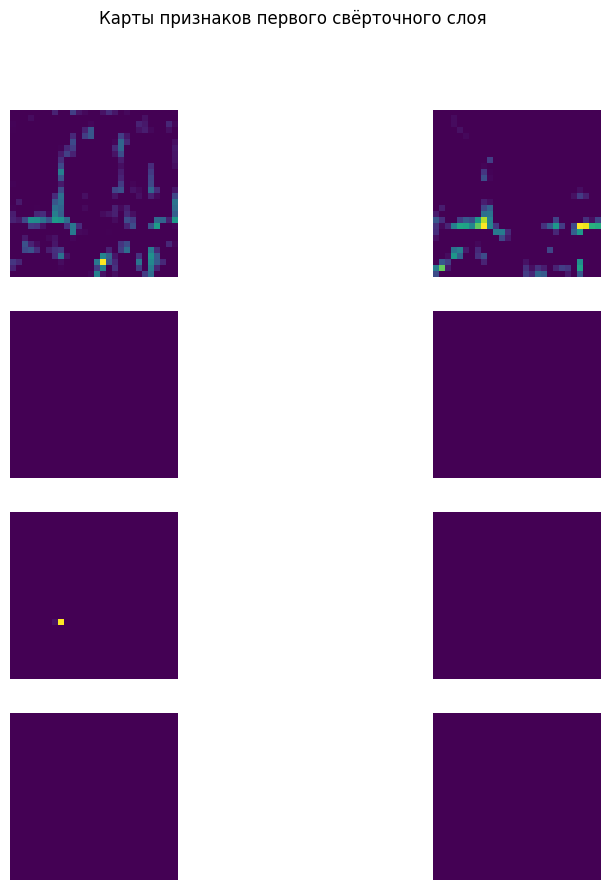

In [106]:
activation_model = Model(inputs=model.get_layer(index=0).input, outputs=model.get_layer('conv2d_34').output)

activations = activation_model.predict(some_image_tensor)

plt.figure(figsize=(10, 10))
for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Карты признаков первого свёрточного слоя')
plt.show()

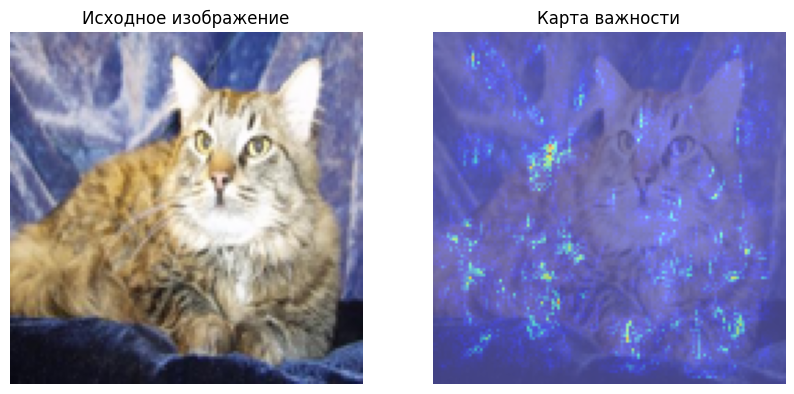

In [109]:
def make_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, img_tensor)

    saliency = tf.abs(grads)
    saliency = tf.reduce_max(saliency, axis=-1)

    return saliency.numpy()[0]

saliency_map = make_saliency_map(some_image_tensor, model)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_tensor[0])
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
saliency_map = saliency_map / np.max(saliency_map)
plt.imshow(img_tensor[0], alpha=0.5)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.title("Карта важности")
plt.axis('off')

plt.show()

### 4. Оценка

In [110]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nТочность на тестовой выборке: {test_acc}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

38/38 - 1s - 39ms/step - accuracy: 0.6592 - loss: 1.9903

Точность на тестовой выборке: 0.659166693687439
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [111]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       621
           1       0.65      0.65      0.65       579

    accuracy                           0.66      1200
   macro avg       0.66      0.66      0.66      1200
weighted avg       0.66      0.66      0.66      1200


Матрица ошибок:
[[417 204]
 [205 374]]


### Модель была скомпилирована с использованием оптимизатора adam и функции потерь binary_crossentropy, которая идеально подходит для бинарной классификации. Во время обучения, мы передали тренировочные и тестовые данные в метод model.fit(). После обучения модель была оценена на тестовой выборке, чтобы определить её точность.

### В итоге, этот подход позволил нам создать базовый классификатор, который работает "с нуля", без использования предварительно обученных моделей.